Este programa clasifica mariposas usando CNN
El dataset de mariposas viene de: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification/data

Damariz Licea A01369045

In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, RandomFlip, RandomRotation, RandomZoom
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomSaturation, RandomHue

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd "/content/drive/MyDrive/tc3002/mairposas"

/content/drive/MyDrive/tc3002/mairposas


In [5]:
tf.random.set_seed(42)
np.random.seed(42)

In [6]:
# Use gpu
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

try:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

except  SystemError as e:
    print(e)

GPU is available
Found GPU at: /device:GPU:0


Este código fue elaborado en Google Colab, por lo tanto el ruteo no corresponde a las carpetas del repositorio.

In [28]:
# Directorios y rutas base
base_dir = '/content/drive/MyDrive/tc3002/mairposas'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
#Existe el CSV de testing pero no trae nada
train_labels_path = os.path.join(base_dir, 'Training_set.csv')

# Manejo de CSV y labels
# Las labels pasan a ser indices
df = pd.read_csv(train_labels_path)
df['filepaths'] = df['filename'].apply(lambda x: os.path.join(train_dir, x))
label_to_index = {label: idx for idx, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_to_index)
print(f"Total de etiquetas: {len(label_to_index)}")

# División en 80% entrenamiento, 10% validación y 10% prueba
# Primero separamos 80% para entrenamiento y 20% para temp
train_df, aux_df = train_test_split(df, test_size=0.2, stratify=df['label_idx'], random_state=42)

# Luego dividimos ese 20% en dos partes iguales (10% y 10% del total)
valid_df, test_df = train_test_split(aux_df, test_size=0.5, stratify=aux_df['label_idx'], random_state=42)

#Cambio en la ultima versión, separar aux para tener test y val, no solo test
print(f"Tamaño del conjunto de entrenamiento: {len(train_df)} imágenes ({len(train_df)/len(df):.1%})")
print(f"Tamaño del conjunto de validación: {len(valid_df)} imágenes ({len(valid_df)/len(df):.1%})")
print(f"Tamaño del conjunto de prueba: {len(test_df)} imágenes ({len(test_df)/len(df):.1%})")


IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# De dataframe a dataset
def df_to_dataset(dataframe, shuffle=True):
    path_ds = tf.data.Dataset.from_tensor_slices(dataframe['filepaths'].values)
    label_ds = tf.data.Dataset.from_tensor_slices(dataframe['label_idx'].values)
    img_ds = path_ds.map(lambda x: tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), IMG_SIZE)/255.0) #imagenes de 128x128 en tres colores
    ds = tf.data.Dataset.zip((img_ds, label_ds))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df, shuffle=False)

Total de etiquetas: 75
Tamaño del conjunto de entrenamiento: 5199 imágenes (80.0%)
Tamaño del conjunto de validación: 650 imágenes (10.0%)
Tamaño del conjunto de prueba: 650 imágenes (10.0%)


In [36]:
# Aumentación: Volteo horizontal, rotación y zoom
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1), #Es en grados. Acuerdate de 2Pi Radianes.
    RandomZoom(0.1), #Zoom in 10%
    RandomBrightness(factor=0.1), #Color Jitter pero poco elegante
    RandomContrast(factor=0.1),
    RandomSaturation(factor=0.05),
    RandomHue(factor=0.05), #Le bajé en todos estos parámetros de .2 a 0.05 o así
  ])

In [37]:
# CNN
# 2 capas convolucionales, 2 capas de pooling, 1 capa densa
model = Sequential([
    data_augmentation,
    Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)), #32 filtros de 3x3 pix-> buscas patrones, cambios
    MaxPooling2D(), # como que lo pasa por la capa chiquita-> si la imag era de 6x6 ahora la analizas en 2x2
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),# vector
    Dense(128, activation='relu'),
    Dense(len(label_to_index), activation='softmax')
])

In [38]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10)
model.save('modelo_mariposas.keras')

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.0137 - loss: 7.0035 - val_accuracy: 0.0215 - val_loss: 4.3165
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.0228 - loss: 4.3163 - val_accuracy: 0.0200 - val_loss: 4.3152
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.0202 - loss: 4.3153 - val_accuracy: 0.0200 - val_loss: 4.3132
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.0219 - loss: 4.3403 - val_accuracy: 0.0138 - val_loss: 4.3170
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.0171 - loss: 4.3168 - val_accuracy: 0.0138 - val_loss: 4.3139
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.0190 - loss: 4.3207 - val_accuracy: 0.0215 - val_loss: 4.2998
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.0210 - loss: 4.3331 - val_accuracy: 0.0200 - val_loss: 4.3058
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.0219 - loss: 4.3130 - 

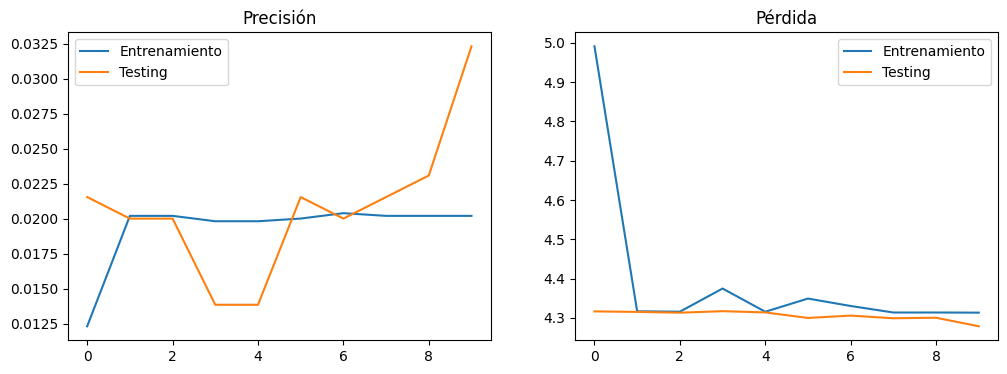

In [40]:
# Desempeño: Accuracy y Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Testing')
plt.title('Precisión')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Testing')
plt.title('Pérdida')
plt.legend()
plt.show()


Imagen: Image_7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicción: MILBERTS TORTOISESHELL (1.49%)


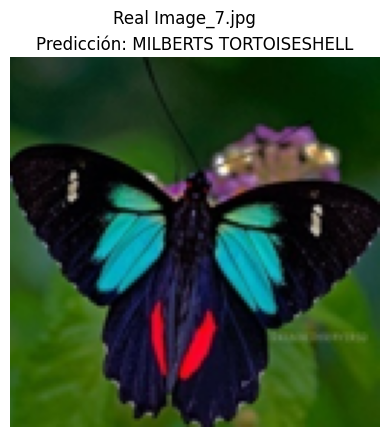

Imagen: Image_4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicción: ORANGE OAKLEAF (1.83%)


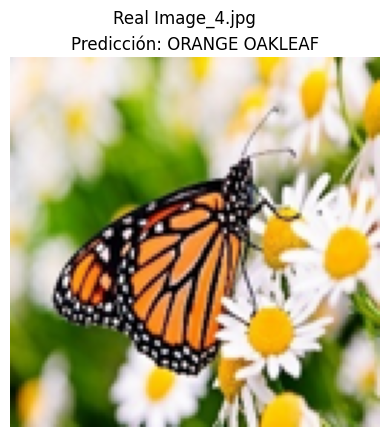

In [33]:
# Función para ver visualmente qué hace el modelo, esta función solo es para mí para entender.
# ahorita solo predice una imagen fija que le das.


def predict_image(img_path):
    img = Image.open(img_path).resize(IMG_SIZE)
    real_name = img_path.split('/')[-1]
    print(f"Imagen: {real_name}")
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # (1, 128, 128, 3)
    pred = model.predict(img_array)[0]
    pred_class = np.argmax(pred)
    confidence = pred[pred_class]

    for label, idx in label_to_index.items():
        if idx == pred_class:
            print(f"Predicción: {label} ({confidence*100:.2f}%)")
            break

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicción: {label}")
    plt.suptitle(f"Real {real_name} ")
    plt.show()

predict_image(df.iloc[6]['filepaths'])
predict_image(df.iloc[3]['filepaths'])


In [ ]:
def confusion_matrix_manual(model, dataset, num_classes):
    matrix = [[0 for _ in range(num_classes)] for _ in range(num_classes)]

    for batch_images, batch_labels in dataset:
        predictions = model.predict(batch_images, verbose=0)
        predicted_classes = np.argmax(predictions, axis=1)

        true_classes = batch_labels.numpy()

        for true, pred in zip(true_classes, predicted_classes):
            matrix[true][pred] += 1

    return matrix


num_classes = len(label_to_index)
matriz = confusion_matrix_manual(model, test_ds, num_classes)


In [35]:
def simple_confusion(matrix):
    correctas = sum(matrix[i][i] for i in range(len(matrix)))
    total = sum(sum(row) for row in matrix)
    incorrectas = total - correctas
    print("\nResumen de Clasificación:")
    print(f"Aciertos (Correctos): {correctas}")
    print(f"Errores (Incorrectos): {incorrectas}")
    print(f"Precisión global: {correctas / total:.2%}")


def resumen_tp_fp_fn_tn(matrix):
    num_classes = len(matrix)
    print("\nMatriz TP/FP/FN/TN por clase:")
    for i in range(num_classes):
        TP = matrix[i][i]
        FN = sum(matrix[i]) - TP
        FP = sum(matrix[j][i] for j in range(num_classes)) - TP
        TN = sum(sum(matrix[j]) for j in range(num_classes)) - (TP + FP + FN)
        print(f"Clase {i} -> TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")

simple_confusion(matriz)
resumen_tp_fp_fn_tn(matriz)



Resumen de Clasificación:
Aciertos (Correctos): 11
Errores (Incorrectos): 639
Precisión global: 1.69%

Matriz TP/FP/FN/TN por clase:
Clase 0 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 1 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 2 -> TP: 0, FP: 0, FN: 10, TN: 640
Clase 3 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 4 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 5 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 6 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 7 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 8 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 9 -> TP: 0, FP: 0, FN: 8, TN: 642
Clase 10 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 11 -> TP: 0, FP: 0, FN: 8, TN: 642
Clase 12 -> TP: 0, FP: 0, FN: 8, TN: 642
Clase 13 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 14 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 15 -> TP: 0, FP: 0, FN: 8, TN: 642
Clase 16 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 17 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 18 -> TP: 0, FP: 0, FN: 8, TN: 642
Clase 19 -> TP: 0, FP: 0, FN: 9, TN: 641
Clase 20 -> TP: 0, FP: 0, FN: 8, TN: 642
Clase 21 -> TP